## MLP statistical language model which uses 3 sequence character to predict next

### 1.1 Load libraries and create dataset

In [20]:
#import library

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

%matplotlib inline

In [21]:
#load data

words = open('names.txt').read().splitlines()
print(len(words))

32033


In [22]:
#encoder and decoder
chars  = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [24]:
#prepare dataset
batch_size = 3

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * batch_size
        for w in word + ".":
            ix = stoi[w]

            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_trn, Y_trn = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

print(X_trn.shape, Y_trn.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### Create vector embedding C for the inputs x

In [25]:
# Initializing network parameters
emb_dim = 10 #embedding vector space
vocab_size =27 #vocab_size is char 'a' to 'z', '.'
h_units = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,emb_dim), generator=g)
W1 = torch.randn((emb_dim*batch_size, h_units), generator=g)
B1 = torch.randn(h_units, generator=g)
W2 = torch.randn((h_units, vocab_size), generator=g)
B2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, B1, W2, B2]

In [26]:
sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [27]:
lossi = []
stepi = []

In [28]:
mini_batch = 32
#model training
for i in range(10000):

    ix = torch.arange(0, X_trn.shape[0], mini_batch,) #mini_batchsize
    emb = C[X_trn[ix]]

    #forward pass
    h = torch.tanh(emb.view(-1,30)@ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y_trn[ix])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #optimize
    lr = 0.1 if i < 5000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    stepi.append(i)

    if i%1000 == 0:
        print(f'{i}/10000 : loss={loss.item(): .4f}')
    lossi.append(loss.log10().item())



0/10000 : loss= 25.6486
1000/10000 : loss= 2.8373
2000/10000 : loss= 2.2243
3000/10000 : loss= 1.9532
4000/10000 : loss= 1.7887
5000/10000 : loss= 1.6760
6000/10000 : loss= 1.6661
7000/10000 : loss= 1.6569
8000/10000 : loss= 1.6479
9000/10000 : loss= 1.6392


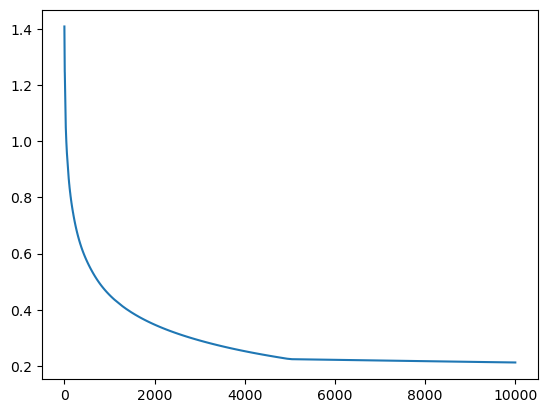

In [30]:
#import os

#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.plot(lossi)
#plt.hist(h.view(-1).tolist(), 50);

### Validation dataset loss & Test dataset loss

In [32]:
@torch.no_grad #decorative to inform stop calculating gradient
def print_split(split):
    X,Y = {'train' : (X_trn, Y_trn),
           'valid': (X_val, Y_val),
           'test' : (X_test, Y_test),
           }[split]

    emb = C[X]
    #forward pass
    h = torch.tanh(emb.view(emb.shape[0],-1)@ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y)
    print(split, loss.item())

print_split('train')
print_split('valid')
print_split('test')

train 3.8761937618255615
valid 3.9231343269348145
test 3.9503419399261475


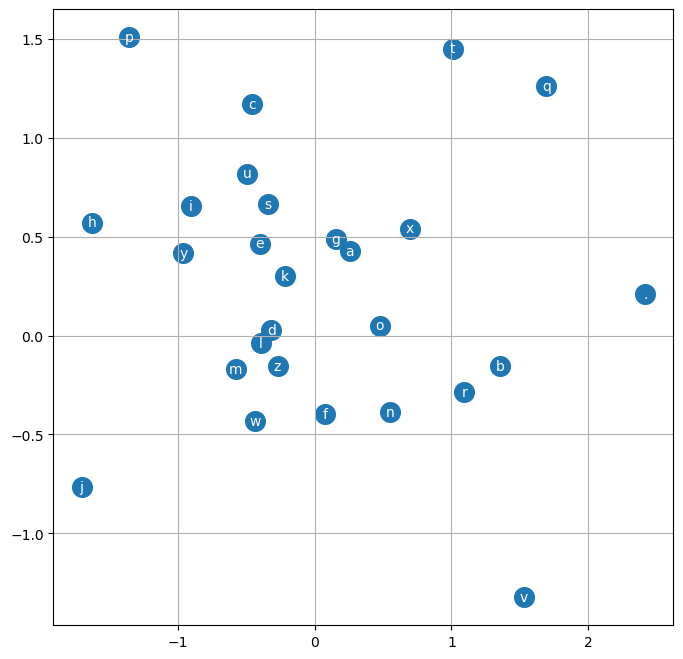

In [31]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Sampling from trained dataset

In [15]:
context = [0] * batch_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [36]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * batch_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        prob = F.softmax(logits, dim=1)

        ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix==0:
            break

    print( ''.join(itos[i] for i in out))

juo.
dek.
anakah.
paytyaan.
bri.
jima.
toroetyngeer.
saania.
yamirinea.
khyani.
roya.
las.
jaqsix.
arthien.
murto.
fodta.
jansy.
sumah.
jayliani.
aysen.
